# All Days Clustering

Combining binned data from all days and clustering.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse

In [2]:
DAYS = ["D{}".format(i) for i in range(0,15,2)]
DAYS

['D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D12', 'D14']

In [3]:
# PROCESSED DATA AT /oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/processed
data = [sc.read_h5ad("/srv/scratch/surag/scATAC-reprog/processed/{}.h5ad".format(day)) for day in DAYS]

In [4]:
# Total cells
sum([d.X.shape[0] for d in data])

60831

In [5]:
# add day label to all observations
for i,d in enumerate(DAYS):
    data[i].obs["day"] = d

data[2].obs.head()

,idx,name,unique_mapped_frag,total_frag,unique_frag,tss_enrichment,reads in tss,log10unique_fragments,new_idx,day
index,,,,,,,,,,
0,292,AAACAACGAATTGCCA,17854,19976,15631,13.624937,13116,4.194015,0.0,D4
1,496,AAACACGCTAGCCATT,27812,30966,24837,13.400627,19488,4.395117,1.0,D4
2,505,AAACACGCTAGCCTAT,28736,32169,24737,14.529915,19691,4.393365,2.0,D4
3,563,AAACACGCTGCAGTTT,13595,15004,11830,15.790850,10101,4.073021,3.0,D4
4,720,AAACATGGAACACAAA,9106,10131,8044,19.274880,7986,3.905526,4.0,D4


### Defining Common Peak Set

**Strategy 1**: take only bins that are present in ALL samples

**Note** that the data has been processed such that those bins that have fewer than 50 total counts have been removed.

In [6]:
intersect_of_var = data[0].var
for i,d in enumerate(DAYS[1:]):
    intersect_of_var = pd.merge(intersect_of_var, data[i+1].var, how='inner', on='idy', validate='one_to_one', suffixes=("", "_x"))

intersect_of_var = intersect_of_var[["idy", "binchr", "binstart", "binend"]]

print(intersect_of_var.shape)
intersect_of_var.head()

(124710, 4)


,idy,binchr,binstart,binend
0,416857,chr19,41126001,41128001
1,807518,chr2,220780001,220782001
2,748159,chr2,102062001,102064001
3,22604,chr13,44904001,44906001
4,1132526,chr6,149896001,149898001


In [7]:
# get the orders of intersection bins for all samples
orders = []
for i,day in enumerate(DAYS):
    mp = {x:j for j,x in enumerate(list(data[i].var.idy))}
    orders.append([mp[idy] for idy in intersect_of_var.idy])

In [8]:
# create new annData
from scipy.sparse import vstack, hstack

intersected_X = vstack([data[i].X[:, orders[i]] for i in range(len(DAYS))])

In [9]:
intersected_anndata = sc.AnnData(X=intersected_X, 
                                 var=intersect_of_var, 
                                 obs=pd.concat([x.obs for x in data], ignore_index=True))

Transforming to str index.
Transforming to str index.


In [10]:
sum([len(data[i].X[:,y].nonzero()[0]) for i,y in enumerate([int(list(x.var[x.var.idy==416857].index)[0]) for x in data])])

2075

In [11]:
len(intersected_anndata.X[:,0].nonzero()[0])

2075

**Strategy 2**: take union of bins

**Note** that the data has been processed such that those bins that have fewer than 50 total counts have been removed.

In [12]:
union_of_var = data[0].var
for i,d in enumerate(DAYS[1:]):
    union_of_var = pd.merge(union_of_var, data[i+1].var, how='outer', on=['idy', 'binchr', 'binstart', 'binend'], validate='one_to_one', suffixes=("", "_x"))

union_of_var = union_of_var[["idy", "binchr", "binstart", "binend"]]

print(union_of_var.shape)
union_of_var

(705544, 4)


,idy,binchr,binstart,binend
0,416857,chr19,41126001,41128001
1,807518,chr2,220780001,220782001
2,748159,chr2,102062001,102064001
3,22604,chr13,44904001,44906001
4,1132526,chr6,149896001,149898001
...,...,...,...,...
705539,905185,chr8,115710001,115712001
705540,1527624,chr9,93720001,93722001
705541,1254223,chr3,40938001,40940001
705542,1232329,chr5,178696001,178698001


In [13]:
# get the orders of intersection bins for all samples
orders = []
for i,day in enumerate(DAYS):
    mp = {x:j for j,x in enumerate(list(data[i].var.idy))}
    # added one since will append a zero row at the beginning of each matrix
    orders.append([mp[idy]+1 if idy in mp else 0 for idy in union_of_var.idy])

In [14]:
# create new annData
zero_appended_data = [hstack([np.zeros((d.X.shape[0],1)), d.X]) for d in data]

unioned_X = vstack([zero_appended_data[i].tocsr()[:, orders[i]] for i in range(len(DAYS))])

In [15]:
unioned_anndata = sc.AnnData(X=unioned_X, 
                             var=union_of_var, 
                             obs=pd.concat([x.obs for x in data], ignore_index=True))

Transforming to str index.
Transforming to str index.


In [16]:
union_of_var.iloc[12322]

idy         1334829
binchr         chr1
binstart    3808001
binend      3810001
Name: 12322, dtype: object

In [17]:
# VERIFYING
# This idy (1334829) is present in 5 samples
sum([1334829 in list(d.var.idy) for d in data])

5

In [18]:
sum([len(x.X[:,int(list(x.var[x.var.idy==1334829].index)[0])].nonzero()[0]) for x in data 
                                                           if 1334829 in list(x.var.idy)])

471

In [19]:
len(unioned_anndata.X[:,12322].nonzero()[0])

471

## Clustering

In [20]:
from copy import deepcopy

# making a copy
dat = deepcopy(intersected_anndata)
# dat = deepcopy(unioned_anndata)

In [21]:
# remove chrM
dat= dat[:, dat.var["binchr"] != "chrM"]
dat.shape

(60831, 124702)

In [22]:
dat.obs["n_counts"] = np.sum(dat.X>0, axis=1).A1

Trying to set attribute `.obs` of view, making a copy.


In [23]:
dat.obs["sqrt_n_counts"] = np.sqrt(dat.obs["n_counts"])
dat.obs["log_n_counts"] = np.log10(1+dat.obs["n_counts"])

In [24]:
np.sum(dat.obs["n_counts"] < 1000)

5391

In [27]:
dat = dat[dat.obs["n_counts"] > 1000, :]

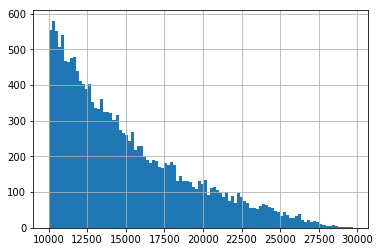

In [28]:
dat.obs.n_counts.hist(bins=100)

In [50]:
# if you want to avoid size normalization issues
dat = dat[dat.obs["n_counts"] > 10000, :]
dat = dat[dat.obs["n_counts"] < 20000, :]
# dat.X.shape

In [51]:
# binarize
dat.X[dat.X!=0] = 1

Trying to set attribute `.X` of view, making a copy.


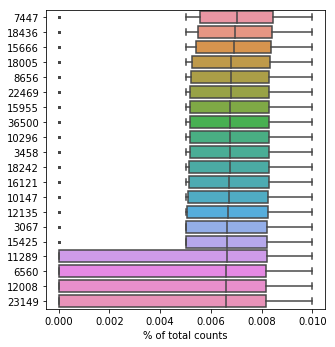

In [52]:
sc.pl.highest_expr_genes(dat, n_top=20)

In [32]:
# sc.pp.normalize_total(dat)
# sc.pp.log1p(dat)

In [33]:
# sc.pp.highly_variable_genes(dat, min_mean=0.0125, max_mean=3, min_disp=1.5)
# sc.pp.highly_variable_genes(dat, min_mean=0.1, max_mean=3, min_disp=1)

In [34]:
# sum(dat.var.highly_variable)

In [35]:
# sc.pl.highly_variable_genes(dat)

In [53]:
dat_filt = dat #[:,dat.var.highly_variable]

In [54]:
from sklearn import random_projection

def scanpy_sparse_rp(
    adta, 
    num_dim_reduced='auto', 
    random_seed=42
):
    """
    Do sparse random projections on data.
    Args:
        adta: Matrix anndata object, with adta.X the feature representation to be projected - a (# cells x # projections) matrix.
    
    Returns:
        Object with .obsm['X_sparse_rp'] a (# cells x # projections) matrix containing the random projections, 
        and .uns['sparse_rp'] the (# features x # projections) matrix used to project down the bins.
    """
    srp = random_projection.SparseRandomProjection(n_components=num_dim_reduced, random_state=random_seed)
    adta.obsm['X_sparse_rp'] = srp.fit_transform(adta.X)
    adta.uns['sparse_rp'] = srp.components_.T    # A row for each orig dimension
    return adta


def regress_out_variables(
    adta, 
    batch_variables = ['sqrt_read_depth'], 
    regress_mode = 'pinv', 
    implicit_rp = True
):
    """
    Three ways of regressing out the batch covariates with linear regression:
    1) regress_mode == 'scanpy': Scanpy default implementation, following Seurat (/SnapATAC)
    2) regress_mode == 'numpy': Direct solution of least-squares problem using numpy
    3) regress_mode == 'pinv': Pseudo-inverse multiplication - faster with a sparse count matrix.
    All give the same answer up to numerical precision.
    """
    if regress_mode == 'scanpy':  # 1st way
        sc.pp.regress_out(adta, batch_variables)
    else:
#         adta.obs['sqrt_read_depth'] = np.sqrt(adta.obs['read_depth'])
        btc = np.vstack([adta.obs[w] for w in batch_variables]).T
        a_exo = np.c_[btc, np.ones(btc.shape[0])]
        if regress_mode == 'numpy': # 2nd way
            x = np.linalg.lstsq(a_exo, adta.X.toarray())[0]
        elif regress_mode == 'pinv': # 3rd way
            pv = np.linalg.pinv(a_exo)
            x = (adta.X.T.dot(pv.T)).T  # Use the sparse matrix's dot() method for speed.
        adta.uns['nuisance_coeffs'] = x
        adta.obsm['nuisance_vars'] = a_exo
        # return adta
        if implicit_rp:
            adta = scanpy_implicit_rp(adta)
        else:
            adta.obsm['residuals'] = adta.X - np.dot(a_exo, x)
#             nuisance_proj = (adta.obsm['residuals'].T.dot(adta.obsm['nuisance_vars'])).T
#             nuisance_proj_magnitudes = np.sqrt(np.ravel(np.sum(np.square(nuisance_proj), axis=1)))
#             old_nuisproj_magnitudes = np.sqrt(np.ravel(np.sum(np.square((adta.X.T.dot(adta.obsm['nuisance_vars'])).T), axis=1)))
#             print("Length of old nuisance signal: {}. Length of new nuisance signal: {}".format(old_nuisproj_magnitudes, nuisance_proj_magnitudes))
    return adta

def scanpy_implicit_rp(
    adta
):
    """
    Calculate projected residuals BR = BR - AXR, 
    where: 
        R is the (regions x components) random projection matrix in adta.uns['sparse_rp'], 
        B is the (cells x regions) data matrix, 
        X is the (nuisance covariates x regions) least-squares solution to the nuisance covariate regression, 
        A is the (cells x nuisance covariates) matrix of nuisance covariates.
    """
    R_mat = adta.uns['sparse_rp']
    BR_mat = adta.obsm['X_sparse_rp']
    A_mat = adta.obsm['nuisance_vars']
    X_mat = adta.uns['nuisance_coeffs']
    proj_nuisance = (R_mat.T.dot(X_mat.T)).T
    adta.obsm['rp_residuals'] = BR_mat - A_mat.dot(proj_nuisance)
    nuisance_proj = A_mat.T.dot(adta.obsm['rp_residuals'])
    nuisance_proj_magnitudes = np.sqrt(np.ravel(np.sum(np.square(nuisance_proj), axis=1)))
    old_nuisproj_magnitudes = np.sqrt(np.ravel(np.sum(np.square(BR_mat.T.dot(A_mat).T), axis=1)))
    print("Length of old nuisance signal: {}. Length of new nuisance signal: {}".format(old_nuisproj_magnitudes, nuisance_proj_magnitudes))
    return adta

In [55]:
dat_filt = scanpy_sparse_rp(dat_filt, num_dim_reduced=30000, random_seed=42)

In [56]:
dat_filt.obsm['X_sparse_rp']

<14727x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 427665355 stored elements in Compressed Sparse Row format>

In [57]:
X_rp_dense = dat_filt.obsm['X_sparse_rp'].toarray()

In [58]:
# dat_filt = regress_out_variables(dat_filt, batch_variables=['n_counts', 'log_n_counts'], regress_mode='pinv', implicit_rp=True)
dat_filt = regress_out_variables(dat_filt, batch_variables=['n_counts'], regress_mode='pinv', implicit_rp=True)

Length of old nuisance signal: [1.13120046e+10 7.98398596e+05]. Length of new nuisance signal: [2.37135311e-05 1.67281650e-09]


In [59]:
# sc.pp.regress_out(dat_filt, ['n_counts'])

In [60]:
rp_residuals = deepcopy(np.array(dat_filt.obsm['rp_residuals']))

In [61]:
# this scales in place
sc.pp.scale(rp_residuals, max_value=10)
# sc.pp.scale(X_rp_dense, max_value=10)
# sc.pp.scale(dat_filt, max_value=10)

In [62]:
rp_residuals_pca = sc.tl.pca(rp_residuals, svd_solver='arpack')
# X_rp_pca = sc.tl.pca(X_rp_dense, svd_solver='arpack')
# sc.tl.pca(dat_filt, svd_solver='arpack')

In [63]:
dat_filt.obsm["X_pca"] = rp_residuals_pca
# dat_filt.obsm["X_pca"] = X_rp_pca

In [64]:
# sc.pl.pca_variance_ratio(dat_filt, log=True)

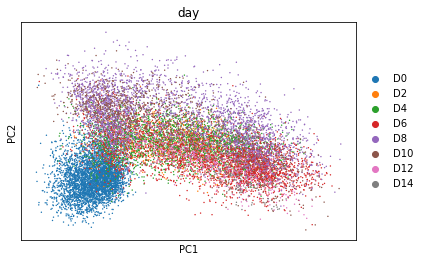

In [66]:
sc.pl.pca(dat_filt, color="n_counts")

In [ ]:
sc.pp.neighbors(dat_filt, n_neighbors=10, n_pcs=40)

In [70]:
sc.tl.umap(dat_filt)

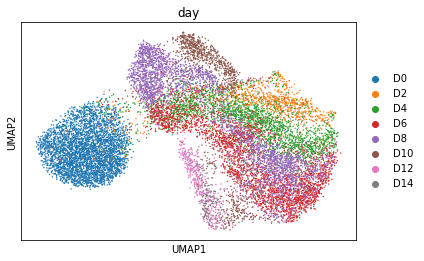

In [72]:
sc.pl.umap(dat_filt, color="day")